In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from xgboost import XGBRegressor


# --- 1. Load and Prepare Data ---

In [9]:
df = pd.read_csv("../data/processed/agg_data_ml.csv")
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values('Data').reset_index(drop=True) # Sort and reset index

# Define Features (X) and Target (y)
X = df.drop(columns=['Data', 'Eólica'])
y = df['Eólica']


# Using 80% for training+validation, 20% for testing
split_index = int(len(df) * 0.8)
X_train_val_orig, X_test_orig = X.iloc[:split_index], X.iloc[split_index:]
y_train_val_orig, y_test_orig = y.iloc[:split_index], y.iloc[split_index:]

# Keep original test set aside
X_test = X_test_orig.copy()
y_test = y_test_orig.copy()

In [10]:
# --- 3. Scaling (Required for ANN) ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers ONLY on the original training+validation data
X_train_val_scaled = scaler_X.fit_transform(X_train_val_orig)
y_train_val_scaled = scaler_y.fit_transform(y_train_val_orig.values.reshape(-1, 1))

# Transform the test data using the fitted scalers
X_test_scaled = scaler_X.transform(X_test_orig)
# y_test is kept unscaled for final evaluation, y_test_scaled needed if evaluating ANN loss directly

# --- 4. Further Split for ANN Validation ---
# Split the scaled training+validation data into training and validation sets for ANN
# Using roughly 85% of train_val for training ANN (~68% overall), 15% for validation (~12% overall)
X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(
    X_train_val_scaled, y_train_val_scaled, test_size=0.15, random_state=42
)

# --- 5. Train Models and Generate Predictions ---

In [11]:
predictions = {}
models_trained = {} # Optional: Store trained models

# == ExtraTrees ==
print("Training ExtraTrees...")
et_model = ExtraTreesRegressor(n_estimators=500, random_state=42, n_jobs=-1)
et_model.fit(X_train_val_orig, y_train_val_orig) # Train on original unscaled data
predictions['ExtraTrees'] = et_model.predict(X_test)
models_trained['ExtraTrees'] = et_model
print("ExtraTrees Done.")

# == RandomForest ==
print("Training RandomForest...")
rf_model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_model.fit(X_train_val_orig, y_train_val_orig) # Train on original unscaled data
predictions['RandomForest'] = rf_model.predict(X_test)
models_trained['RandomForest'] = rf_model
print("RandomForest Done.")

# == Gradient Boosting ==
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=500, random_state=42)
gb_model.fit(X_train_val_orig, y_train_val_orig) # Train on original unscaled data
predictions['GradientBoosting'] = gb_model.predict(X_test)
models_trained['GradientBoosting'] = gb_model
print("Gradient Boosting Done.")

# == XGBoost ==
print("Training XGBoost...")
xgb_model = XGBRegressor(n_estimators=500, random_state=42, verbosity=0, n_jobs=-1)
xgb_model.fit(X_train_val_orig, y_train_val_orig) # Train on original unscaled data
predictions['XGBoost'] = xgb_model.predict(X_test)
models_trained['XGBoost'] = xgb_model
print("XGBoost Done.")

# == ANN ==
print("Training ANN...")

ann_model = Sequential([
    Input((X_train_ann.shape[1],)),
    # Dense(64, activation='relu', ),
    # Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear') # Use linear activation for regression output
])


ann_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop = EarlyStopping(
    monitor='val_mae',
    patience=50, # Increased patience might be needed
    restore_best_weights=True
)

history = ann_model.fit(
    X_train_ann, y_train_ann,
    validation_data=(X_val_ann, y_val_ann),
    epochs=200,       # Increased epochs, early stopping will handle it
    batch_size=32,    # Adjusted batch size
    callbacks=[early_stop],
    verbose=0 # Set to 1 if you want to see training progress
)

# Predict on scaled test data
y_pred_scaled_ann = ann_model.predict(X_test_scaled, verbose=0)
# Inverse transform predictions to original scale
predictions['ANN'] = scaler_y.inverse_transform(y_pred_scaled_ann).flatten() # flatten array
models_trained['ANN'] = ann_model
print("ANN Done.")

Training ExtraTrees...
ExtraTrees Done.
Training RandomForest...
RandomForest Done.
Training Gradient Boosting...
Gradient Boosting Done.
Training XGBoost...
XGBoost Done.
Training ANN...
ANN Done.



--- Comparison DataFrame (First 5 rows) ---
      Eolica_Real  Eolica_Pred_ExtraTrees  Eolica_Pred_RandomForest  \
3213     123195.1             105059.2682               107394.5250   
3214     155748.0             107566.5046               110247.9060   
3215     183423.7             199286.4184               198551.1818   
3216     178352.1             180638.6324               181293.2120   
3217      60869.3              75162.5282                71609.7096   

      Eolica_Pred_GradientBoosting  Eolica_Pred_XGBoost  Eolica_Pred_ANN  
3213                 107977.404967        127094.031250    120151.804688  
3214                 103317.032423        106265.882812     95602.906250  
3215                 209854.759963        187479.125000    190233.843750  
3216                 192626.102925        181992.562500    196552.078125  
3217                  64104.740041         70001.429688     74596.710938  

--- Comparison DataFrame (Last 5 rows) ---
      Eolica_Real  Eolica_Pred_Ext

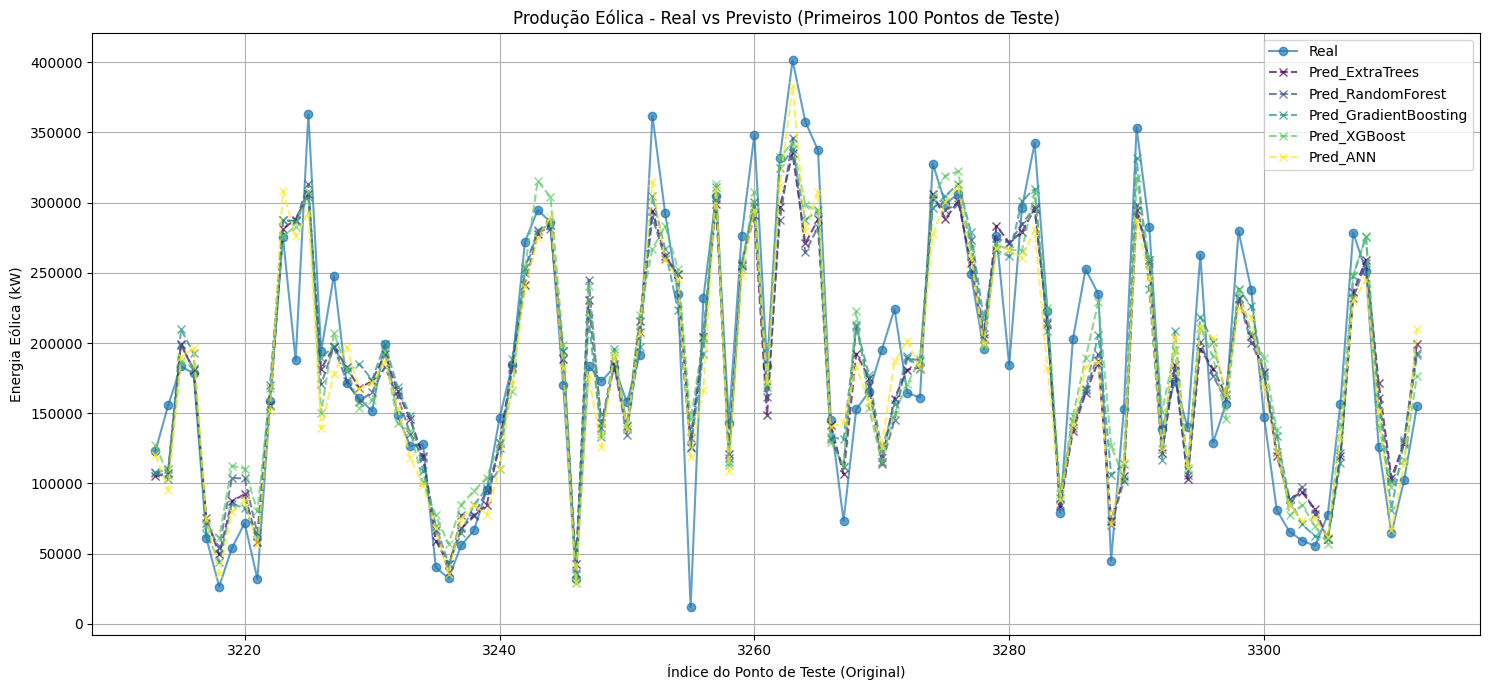

In [12]:
# --- 6. Combine Actual Values and Predictions ---

# Use the index from the original y_test for alignment
comparison_df = pd.DataFrame({'Eolica_Real': y_test.values}, index=y_test.index)

for model_name, preds in predictions.items():
    # Ensure predictions align with y_test index
    comparison_df[f'Eolica_Pred_{model_name}'] = pd.Series(preds, index=y_test.index)

print("\n--- Comparison DataFrame (First 5 rows) ---")
print(comparison_df.head())
print("\n--- Comparison DataFrame (Last 5 rows) ---")
print(comparison_df.tail())


# --- 7. Calculate and Display Metrics ---

metrics = {}
for model_name, preds in predictions.items():
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    # Calculate MAPE - multiply by 100 to express as a percentage
    # Note: MAPE can be infinite if y_test contains zeros. Handle appropriately if needed.
    # Replace zeros in y_test with a small number if MAPE calculation fails or gives inf
    y_test_safe = y_test.copy()
    y_test_safe[y_test_safe == 0] = 1e-6 # Replace 0 with a small epsilon to avoid division by zero
    mape = mean_absolute_percentage_error(y_test_safe, preds) * 100
    metrics[model_name] = {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape}

metrics_df = pd.DataFrame(metrics).T # Transpose for better readability

print("\n--- Evaluation Metrics ---")
print(metrics_df)

# Optional: Plotting comparison (example for the first 100 test points)
plt.figure(figsize=(15, 7))
plt.plot(comparison_df.index[:100], comparison_df['Eolica_Real'][:100], label='Real', marker='o', linestyle='-', alpha=0.7)

colors = plt.cm.viridis(np.linspace(0, 1, len(predictions))) # Get distinct colors

for i, (model_name, preds) in enumerate(predictions.items()):
    plt.plot(comparison_df.index[:100], comparison_df[f'Eolica_Pred_{model_name}'][:100],
             label=f'Pred_{model_name}', marker='x', linestyle='--', alpha=0.7, color=colors[i])

plt.title('Produção Eólica - Real vs Previsto (Primeiros 100 Pontos de Teste)')
plt.xlabel('Índice do Ponto de Teste (Original)')
plt.ylabel('Energia Eólica (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- **Overall Performance**: R² values are all around 0.80-0.83. This is reasonably good, indicating the models capture a significant portion of the variance. RMSE and MAE values are in the 30,000-40,000 range (likely kWh based on previous context). MAPE is around 37-38%.
- **Best Performers**: RandomForest and ExtraTrees (both bagging ensembles) seem slightly better on R², MAE, and RMSE. Gradient Boosting and ANN are close behind. XGBoost is slightly lower in R² but comparable in MAE/RMSE/MAPE.
- **MAPE**: The MAPE values are relatively high (37-38%). This suggests that while the R² is decent, the percentage error can still be substantial, especially possibly on days with lower production (where the denominator in MAPE is small).
- **Consistency**: The models are performing relatively similarly. There isn't one standout winner by a huge margin, suggesting the current features and basic model structures might be hitting a plateau.